In [1]:
import polars as pl
import numpy as np
import matplotlib.pyplot as plt

from catboost import Pool, CatBoostClassifier
from sklearn.metrics import roc_auc_score

In [2]:
import pandas as pd

try:
    import pyarrow
    print("PyArrow is installed. Version:", pyarrow.__version__)
except ModuleNotFoundError:
    print("PyArrow is NOT found in this environment. You installed it in a different one.")

PyArrow is installed. Version: 23.0.1


In [3]:
### Часть 1, смотрим данные

# Сперва подгрузим данные и посмотрим с чем нам предстоит работать.
# Участникам предоставляются 2 пары файлов с признаками (train и test):
# 1. train_main_features.parquet + test_main_features.parquet (199 признаков + ключ)
# 2. train_extra_features.parquet + test_extra_features.parquet (2241 признак + ключ)

# ##### Часть 1.1 данные признаков
# Попробуем сперва поработать с первым набором (*_main_features.parquet*).
# ВНИМАНИЕ: Для избежания ошибок памяти (bad allocation) мы не подключаем extra_features в этом базовом решении.

train = pl.read_parquet('train_main_features.parquet')
test = pl.read_parquet('test_main_features.parquet')

print('Тренировочные данные:', train.shape)
print('Тестовые данные:', test.shape)

Тренировочные данные: (750000, 200)
Тестовые данные: (250000, 200)


In [4]:
train.head(n = 5)

customer_id,cat_feature_1,cat_feature_2,cat_feature_3,cat_feature_4,cat_feature_5,cat_feature_6,cat_feature_7,cat_feature_8,cat_feature_9,cat_feature_10,cat_feature_11,cat_feature_12,cat_feature_13,cat_feature_14,cat_feature_15,cat_feature_16,cat_feature_17,cat_feature_18,cat_feature_19,cat_feature_20,cat_feature_21,cat_feature_22,cat_feature_23,cat_feature_24,cat_feature_25,cat_feature_26,cat_feature_27,cat_feature_28,cat_feature_29,cat_feature_30,cat_feature_31,cat_feature_32,cat_feature_33,cat_feature_34,cat_feature_35,cat_feature_36,…,num_feature_96,num_feature_97,num_feature_98,num_feature_99,num_feature_100,num_feature_101,num_feature_102,num_feature_103,num_feature_104,num_feature_105,num_feature_106,num_feature_107,num_feature_108,num_feature_109,num_feature_110,num_feature_111,num_feature_112,num_feature_113,num_feature_114,num_feature_115,num_feature_116,num_feature_117,num_feature_118,num_feature_119,num_feature_120,num_feature_121,num_feature_122,num_feature_123,num_feature_124,num_feature_125,num_feature_126,num_feature_127,num_feature_128,num_feature_129,num_feature_130,num_feature_131,num_feature_132
i32,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,…,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
1000001,1.0,0.0,2.0,1.0,2.0,3.0,2.0,2.0,4.0,2.0,0.0,0.0,0.0,1.0,2.0,0.0,2.0,2.0,2.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,1.0,2.0,1.0,2.0,2.0,0.0,0.0,212.0,0.0,0.0,…,-0.284519,null,-0.004499,null,-0.050159,-0.002297,-0.043592,-0.061488,0.450342,null,0.0,null,-0.060492,-0.279105,null,-0.429813,null,-0.009654,-0.293036,null,-0.493959,-0.019079,null,null,null,null,-0.001357,-0.031281,-0.046146,null,-0.445279,null,null,-0.107666,-0.418616,null,null
1000002,1.0,0.0,0.0,1.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,212.0,1.0,0.0,…,-0.284519,0.460275,-0.004278,null,-0.556244,-0.002297,-0.043592,-0.061488,1.998252,-0.009552,0.0,-0.005762,-0.060492,-0.279105,null,-0.429813,null,-0.009654,-0.293036,-0.004421,-0.256445,-0.014154,null,-0.24167,null,null,-0.001357,-0.031281,-0.046146,-0.10217,1.550722,null,null,-0.170724,-0.805771,-0.397803,-0.373734
1000003,1.0,0.0,0.0,1.0,0.0,3.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,212.0,0.0,0.0,…,-0.284519,-0.264397,-0.004278,null,null,-0.002297,-0.043592,-0.061488,-0.264078,null,0.0,-0.26649,-0.060492,-0.279105,null,-0.429813,null,-0.009654,-0.293036,-0.004421,-0.57313,-0.019124,null,-0.24167,null,null,-0.001357,-0.031281,-0.046146,null,-0.475778,null,null,-0.170724,-0.602005,-0.397803,-0.373734
1000004,1.0,0.0,2.0,1.0,2.0,3.0,2.0,2.0,3.0,2.0,0.0,0.0,0.0,1.0,2.0,2.0,2.0,2.0,2.0,0.0,0.0,2.0,2.0,0.0,0.0,0.0,0.0,2.0,1.0,2.0,2.0,0.0,0.0,212.0,0.0,0.0,…,-0.284519,null,-0.004499,null,null,-0.002297,-0.043592,-0.061488,0.688482,-0.009552,0.0,null,-0.060492,null,null,-0.429813,null,-0.009654,-0.293036,null,-0.57313,null,null,-0.505441,null,0.714631,-0.001357,-0.031281,-0.046146,null,-0.475778,0.111196,0.116695,null,-0.724265,null,null
1000005,1.0,2.0,0.0,1.0,0.0,3.0,0.0,0.0,2.0,1.0,2.0,2.0,2.0,0.0,1.0,0.0,0.0,0.0,0.0,2.0,2.0,2.0,0.0,2.0,2.0,2.0,2.0,0.0,0.0,0.0,0.0,2.0,2.0,212.0,2.0,2.0,…,-0.284519,-0.264397,-0.004499,null,null,-0.002297,-0.043592,null,-0.264078,null,0.0,-0.26649,null,-0.279105,null,-0.429813,null,-0.009654,-0.293036,-0.004421,-0.57313,-0.018674,null,null,null,null,null,null,-0.046146,null,null,null,null,-0.107666,null,-0.397803,-0.373734


In [5]:
# Легенда гласит, что в данных достаточно много пропусков.
# Так ли это?

missing_values = (
    train.null_count()
    .unpivot(variable_name="Column", value_name="Missing Values")
    .filter(pl.col("Missing Values") > 0)
    .sort("Missing Values", descending=True)
)

print('\nКоличество пропусков в признаках:\n', missing_values)


Количество пропусков в признаках:
 shape: (132, 2)
┌─────────────────┬────────────────┐
│ Column          ┆ Missing Values │
│ ---             ┆ ---            │
│ str             ┆ u32            │
╞═════════════════╪════════════════╡
│ num_feature_43  ┆ 749166         │
│ num_feature_54  ┆ 748897         │
│ num_feature_64  ┆ 748761         │
│ num_feature_34  ┆ 748228         │
│ num_feature_118 ┆ 747082         │
│ …               ┆ …              │
│ num_feature_27  ┆ 31045          │
│ num_feature_58  ┆ 18722          │
│ num_feature_76  ┆ 18542          │
│ num_feature_62  ┆ 18540          │
│ num_feature_98  ┆ 3215           │
└─────────────────┴────────────────┘


In [6]:
# Нам также известно, что часть признаков в данных — категориальная.
# По легенде их можно найти по названиям "cat_feature".
# Эти категориальные признаки стоит отдельно выделить и сохранить для Catboost. 

cat_feature_names = [
    col_name for col_name in train.columns
    if col_name.startswith("cat_feature")
]

In [7]:
train = train.with_columns(
    pl.col(cat_feature_names).cast(pl.Int32)
)

In [8]:
# ##### Часть 1.2 целевые переменные

# В задаче предоставлена информация о 41 банковском продукте.
# Информацию о наличии каждого продукта требуется классифицровать по отдельности, в рамках multi-label постановки.

target = pl.read_parquet('train_target.parquet')

In [9]:
target.head(n = 5)

customer_id,target_1_1,target_1_2,target_1_3,target_1_4,target_1_5,target_2_1,target_2_2,target_2_3,target_2_4,target_2_5,target_2_6,target_2_7,target_2_8,target_3_1,target_3_2,target_3_3,target_3_4,target_3_5,target_4_1,target_5_1,target_5_2,target_6_1,target_6_2,target_6_3,target_6_4,target_6_5,target_7_1,target_7_2,target_7_3,target_8_1,target_8_2,target_8_3,target_9_1,target_9_2,target_9_3,target_9_4,target_9_5,target_9_6,target_9_7,target_9_8,target_10_1
i32,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
1000001,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1000002,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1000003,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1000004,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1000005,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [10]:
# Давайте поверхностно посмотрим на то. с чем нам предстоит работать

target_columns = [col for col in target.columns if col.startswith("target")]

In [11]:
target_col_means = (
    target.select(pl.col(target_columns).mean())
    .transpose(include_header = True, column_names = ["Mean"])
    .rename({"column": "Target"})
    #.sort("Sum", descending=True)
)

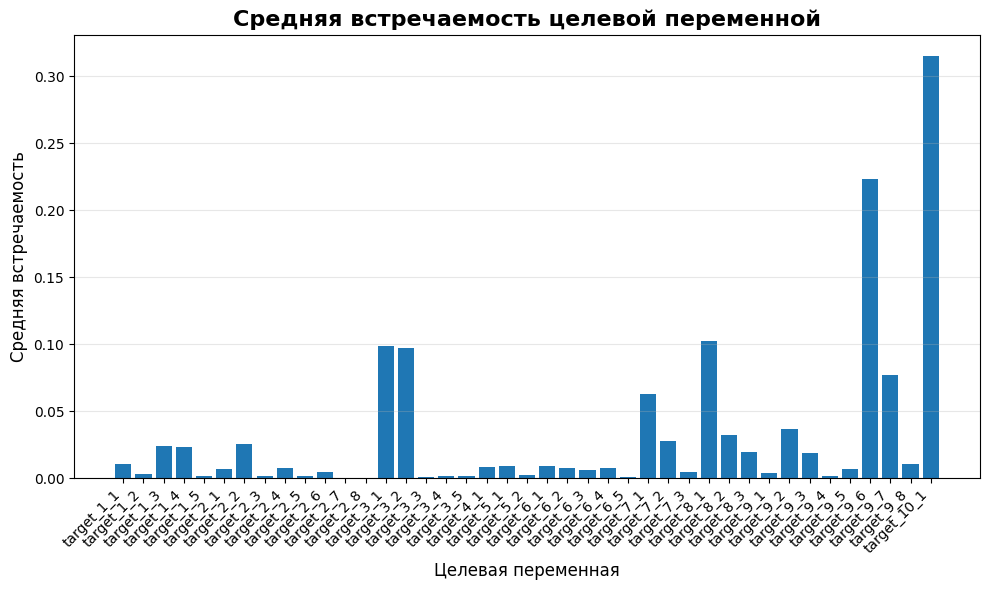

In [12]:
plt.figure(figsize = (10, 6))

bars = plt.bar(target_col_means["Target"], target_col_means["Mean"])

plt.title("Средняя встречаемость целевой переменной", fontsize = 16, fontweight='bold')
plt.xlabel("Целевая переменная", fontsize = 12)
plt.ylabel("Средняя встречаемость", fontsize = 12)
plt.xticks(rotation = 45, ha = 'right', fontsize = 10)
plt.grid(axis = 'y', alpha = 0.3)

plt.tight_layout()
plt.show()

In [13]:
# Выглядит интересно. И несбалансированно :)
# Интересно, а что у них с совместной встречаемостью?

target_row_sums = target.select(
    pl.sum_horizontal(target_columns).alias("row_sum")
)

target_row_sums.describe()

statistic,row_sum
str,f64
"""count""",750000.0
"""null_count""",0.0
"""mean""",1.303459
"""std""",0.716945
"""min""",1.0
"""25%""",1.0
"""50%""",1.0
"""75%""",1.0
"""max""",11.0


In [14]:
target_corr_matrix = (
    target.select(target_columns)
    .corr()
    .to_numpy()
)

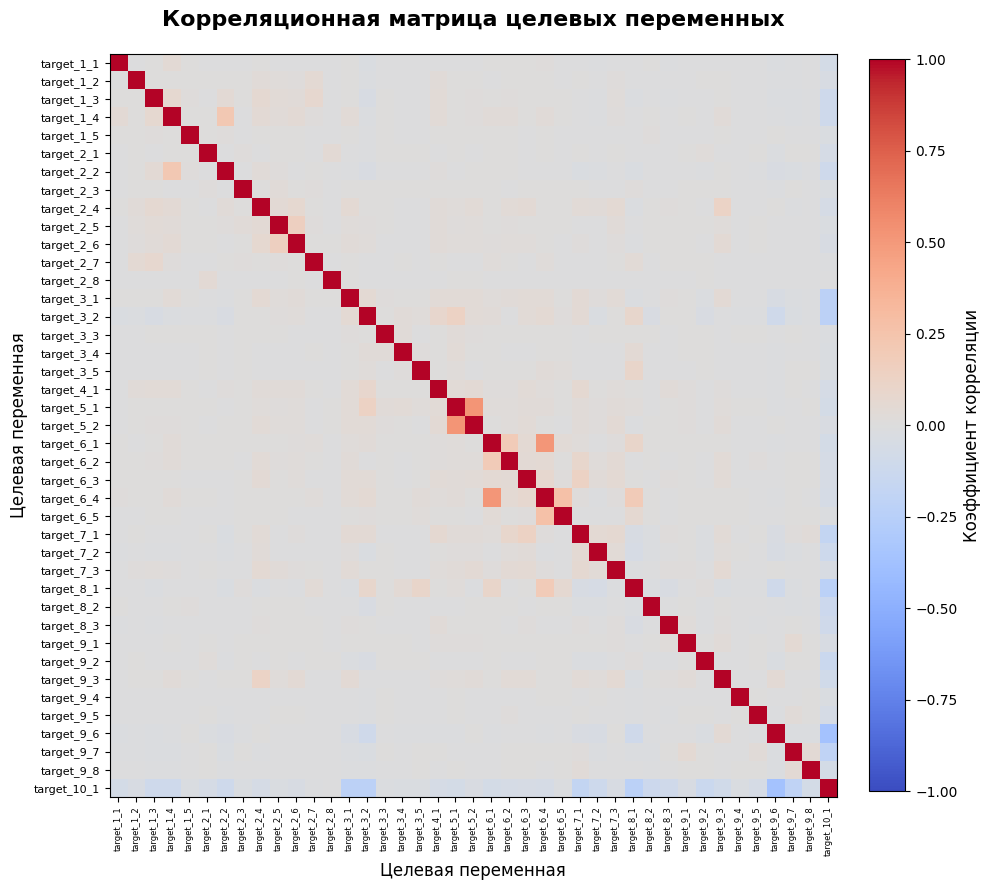

In [15]:
plt.figure(figsize=(10, 9))
im = plt.imshow(target_corr_matrix, cmap = 'coolwarm', vmin = -1, vmax = 1, aspect = 'auto')

cbar = plt.colorbar(im, fraction = 0.046, pad = 0.04)
cbar.set_label('Коэффициент корреляции', fontsize = 12)

plt.title("Корреляционная матрица целевых переменных", fontsize = 16, fontweight = 'bold', pad = 20)
plt.xlabel("Целевая переменная", fontsize = 12)
plt.ylabel("Целевая переменная", fontsize = 12)

plt.xticks(np.arange(len(target_columns)), target_columns, rotation = 90, fontsize = 6)
plt.yticks(np.arange(len(target_columns)), target_columns, fontsize = 8)

plt.tight_layout()
plt.show()

In [16]:
### Часть 2, обучаем Catboost

# К счастью для нас, Catboost умеет "из коробки" работать и с пропусками, и (важно для нас) с multi-class и multi-label классификацией.
# Попробуем обучить модель "в лоб", оставив более интересные возможности и надстройки для участников соревнования :)

# ##### Часть 2.1 подготовка данных
# - Опустим сам customer_id
# - Не забудем про ранее сохраненные категориальные признаки
# - Найдем в документации Catboost настройку "MultiLogLoss"
# - Будем осторожны в первом подходе к снаряду, так как деревьев будет строиться много

# =============================================================================
# ИЗМЕНЕНИЕ: СЛУЧАЙНАЯ ВЫБОРКА (METHOD 2)
# Для избежания ошибки "bad allocation" и ускорения экспериментов,
# мы берем случайную подвыборку из тренировочных данных перед обучением.
# =============================================================================

import gc

# Параметры сэмплирования
SAMPLE_FRACTION = 0.2  # Берем 20% данных (150,000 строк вместо 750,000)
RANDOM_SEED = 42

print(f"Выполняем сэмплирование данных ({SAMPLE_FRACTION * 100}% от исходного набора)...")

# Делаем сэмпл с фиксированным seed для воспроизводимости
# Важно: Предполагается, что порядок строк в train и target идентичен (по customer_id)
train_sample = train.sample(fraction=SAMPLE_FRACTION, seed=RANDOM_SEED)
target_sample = target.sample(fraction=SAMPLE_FRACTION, seed=RANDOM_SEED)

# Освобождаем память от полных данных, если они больше не нужны для EDA
del train, target
gc.collect()

print(f"Размер выборки для обучения: {train_sample.shape}")

# Создаем Pool уже на основе сэмплированных данных
train_pool = Pool(data = train_sample.drop("customer_id").to_pandas(),
                  label = target_sample.drop("customer_id").to_pandas(),
                  cat_features = cat_feature_names)

# Очищаем память после создания пула
del train_sample, target_sample
gc.collect()

Выполняем сэмплирование данных (20.0% от исходного набора)...
Размер выборки для обучения: (150000, 200)


0

In [17]:
# Настройка модели
# Добавлен параметр thread_count для контроля потребления памяти
model = CatBoostClassifier(iterations = 100,
                           depth = 6,
                           learning_rate = 0.1,
                           loss_function = 'MultiLogloss',
                           nan_mode = 'Min',
                           random_seed = 1234,
                           verbose = 1,
                           thread_count = -1,
                           early_stopping_rounds=15,
                           bootstrap_type='Bernoulli',
                           subsample=0.5,
                           l2_leaf_reg=3.0)

# Обучаем модель
# Внимание: Важно следить за потреблением памяти, особенно если данных много
print("Начинаем обучение CatBoost...")
print("Убедитесь, что у вас достаточно оперативной памяти!")
print("Если видите ошибку 'bad allocation', уменьшите размер выборки или используйте меньше признаков")

Начинаем обучение CatBoost...
Убедитесь, что у вас достаточно оперативной памяти!
Если видите ошибку 'bad allocation', уменьшите размер выборки или используйте меньше признаков


In [ ]:
# Поехали :)
# P.S. Это займет какое-то время, так что можно сходить попить чай
# Теперь обучение должно пройти стабильнее благодаря сэмплированию

model.fit(train_pool)

0:	learn: 0.4949441	total: 8.11s	remaining: 13m 22s
1:	learn: 0.3663730	total: 16.3s	remaining: 13m 16s
2:	learn: 0.2795210	total: 40.4s	remaining: 21m 47s
3:	learn: 0.2234445	total: 1m 21s	remaining: 32m 45s
4:	learn: 0.1861027	total: 2m 10s	remaining: 41m 23s
5:	learn: 0.1604796	total: 2m 59s	remaining: 46m 45s
6:	learn: 0.1437889	total: 3m 22s	remaining: 44m 53s
7:	learn: 0.1310704	total: 4m 12s	remaining: 48m 25s
8:	learn: 0.1227388	total: 4m 29s	remaining: 45m 20s
9:	learn: 0.1158302	total: 5m 17s	remaining: 47m 37s
10:	learn: 0.1106214	total: 6m 8s	remaining: 49m 42s
11:	learn: 0.1070635	total: 6m 57s	remaining: 51m 1s
12:	learn: 0.1039407	total: 7m 46s	remaining: 51m 59s
13:	learn: 0.1016611	total: 8m 36s	remaining: 52m 51s
14:	learn: 0.0997595	total: 9m 27s	remaining: 53m 34s
15:	learn: 0.0982539	total: 10m 16s	remaining: 53m 54s
16:	learn: 0.0970989	total: 11m 3s	remaining: 54m
17:	learn: 0.0960132	total: 11m 53s	remaining: 54m 9s
18:	learn: 0.0954169	total: 12m 24s	remaining:

In [ ]:
model.save_model('catboost_model.cbm')

In [ ]:
# Построить learning curve
import matplotlib.pyplot as plt
plt.plot(range(len(model.evals_result_['learn']['MultiLogloss'])), 
         model.evals_result_['learn']['MultiLogloss'])
plt.title('Learning Curve - 50 iterations')
plt.xlabel('Iteration')
plt.ylabel('MultiLogloss')
plt.grid(True)
plt.show()

In [ ]:
# Посмотреть важность признаков
feature_importance = model.get_feature_importance()
# Топ-10 признаков
top_features = sorted(zip(train_pool.get_feature_names(), 
                          feature_importance), 
                     key=lambda x: x[1], reverse=True)[:10]
print("Топ-10 важных признаков:")
for feat, imp in top_features:
    print(f"{feat}: {imp:.4f}")

In [ ]:
# Настройку валидации и гиперпараметров оставим уже для участников соревнования 🤗

### Часть 3, подготовка сабмита

# Посмотрим на пример рабочего бейзлайн решения.
# Именно в таком формате платформа ждет от нас решения:

sample_submit = pl.read_parquet('sample_submit.parquet')

sample_submit.head(n = 5)

In [ ]:
# После того как посмотрели, осознали. Можем и сами все сделать :)
# Сперва стоит сделать предсказания с помощью Catboost-а на тестовых данных. 
# А для этого к ним стоит не забыть применить все те же манипуляции, что мы делали и с тренировочными данными (до обучения Catboost-а).

test.head(n = 5)

In [ ]:
test = test.with_columns(
    pl.col(cat_feature_names).cast(pl.Int32)
)

In [ ]:
test_pool = Pool(data = test.drop("customer_id").to_pandas(),
                 cat_features = cat_feature_names)

In [ ]:
# Делаем предсказания обученной ранее моделью.
# Предсказания будут в форме numpy.ndarray в 41 столбец.

test_predict = model.predict(test_pool, prediction_type = "RawFormulaVal")

test_predict.shape

In [ ]:
# Пойдем по долгому пути и сами соберем свой submit файл.

predict_schema = [col.replace("target_", "predict_") for col in target_columns]

catboost_predictions = pl.DataFrame(test_predict, schema = predict_schema)

catboost_predictions.head(n = 5)

In [ ]:
submit = test.select("customer_id")

submit = submit.hstack(catboost_predictions)

In [ ]:
submit.head(n = 5)

In [ ]:
# Выглядит похоже на правду :)
# Осталось только сохранить файл в .parquet и отправить на платформу, чтобы получить результат.

submit.write_parquet("sample_submit.parquet")